In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Dense, LSTM, TimeDistributed, GRU, SimpleRNN
from keras.models import Model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [0]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
#Separating the data into training and test sets, start arg is the index to start from in case needed to dismiss the early rows as they were quite off from the mid
def train_test_split(X, y, start=0, ratio=0.2):
  
  samples = int(X[start:].shape[0] * (1 - ratio))
  idx_to = start + samples
  
  X_train = X[start:idx_to, :]
  y_train = y[start:idx_to, :]
  X_test = X[idx_to:, :]
  y_test = y[idx_to:, :]
  
  return X_train, y_train, X_test, y_test


In [0]:

def reshape_to_batches(a, batch_size):
    #pad if the length is not divisible by the batch_size
    batch_num = np.ceil(a.shape[0] / float(batch_size))
    modulo = batch_num * batch_size - a.shape[0]
    if modulo != 0:
        pad = np.zeros((int(modulo), a.shape[1]))
        a = np.vstack((a, pad))
    return np.array(np.split(a, batch_num))

In [0]:
#function to transform 3d batches to 2d
def _3d_to_2d(arr):
    return arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2])

**Regression Model representation: **

In [0]:
file_1 = '/content/drive/My Drive/Vega/MachineLearning/data/binance/train_df_80.csv' #data generated using current mid trade prices, Y is current mid too

In [7]:
data = pd.read_csv(file_1)
pd.set_option('display.max_columns', 82)
data.rename(columns={'Unnamed: 0':'TimeStamp'}, inplace=True)
print(data.shape)
data.head()

(9514, 82)


,TimeStamp,B_P1,B_V1,B_P2,B_V2,B_P3,B_V3,B_P4,B_V4,B_P5,B_V5,B_P6,B_V6,B_P7,B_V7,B_P8,B_V8,B_P9,B_V9,B_P10,B_V10,B_P11,B_V11,B_P12,B_V12,B_P13,B_V13,B_P14,B_V14,B_P15,B_V15,B_P16,B_V16,B_P17,B_V17,B_P18,B_V18,B_P19,B_V19,B_P20,B_V20,S_P1,S_V1,S_P2,S_V2,S_P3,S_V3,S_P4,S_V4,S_P5,S_V5,S_P6,S_V6,S_P7,S_V7,S_P8,S_V8,S_P9,S_V9,S_P10,S_V10,S_P11,S_V11,S_P12,S_V12,S_P13,S_V13,S_P14,S_V14,S_P15,S_V15,S_P16,S_V16,S_P17,S_V17,S_P18,S_V18,S_P19,S_V19,S_P20,S_V20,Mid
0,1.521332e+09,0.069306,0.334,0.069309,0.015,0.069313,0.367,0.069314,4.328,0.069316,0.400,0.069319,0.016,0.069337,0.299,0.069343,0.275,0.069360,0.130,0.069363,0.109,0.069373,20.000,0.069374,0.536,0.069376,0.074,0.069378,0.040,0.069400,1.219,0.069404,0.269,0.069406,0.084,0.069416,0.090,0.069429,0.327,0.069430,0.864,0.069556,0.000,0.069556,0.000,0.069556,0.00,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.00,0.069556,0.0,0.069556,0.0,0.069557,0.000,0.069556,1.724,0.069557,0.283,0.069558,4.166,0.069559,0.870,0.069560,23.200,0.069568,0.372,0.069569,1.248,0.069578
1,1.521333e+09,0.069009,0.334,0.069010,0.279,0.069011,0.030,0.069012,0.016,0.069016,0.350,0.069030,0.058,0.069039,0.320,0.069042,0.539,0.069050,0.500,0.069054,0.015,0.069065,0.179,0.069076,0.129,0.069082,0.184,0.069095,0.261,0.069099,0.370,0.069100,5.115,0.069105,3.040,0.069106,3.441,0.069160,0.471,0.069161,0.328,0.069216,0.000,0.069216,0.000,0.069216,0.00,0.069216,0.000,0.069216,0.000,0.069216,0.000,0.069217,0.000,0.069217,0.000,0.069217,0.000,0.069218,0.00,0.069219,0.0,0.069221,0.0,0.069226,0.000,0.069215,1.451,0.069237,0.500,0.069238,0.001,0.069241,0.278,0.069244,1.933,0.069247,0.536,0.069250,19.809,0.069264
2,1.521333e+09,0.068680,1.000,0.068690,1.001,0.068694,0.475,0.068695,2.238,0.068700,0.111,0.068708,0.350,0.068710,5.000,0.068715,0.050,0.068733,0.275,0.068739,0.370,0.068740,1.149,0.068741,0.410,0.068743,0.390,0.068749,0.015,0.068750,0.404,0.068751,0.080,0.068778,5.188,0.068779,2.916,0.068780,0.676,0.068781,0.390,0.068873,0.000,0.068873,0.000,0.068873,0.00,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.00,0.068873,0.0,0.068873,0.0,0.068873,0.000,0.068874,0.000,0.068873,1.528,0.068874,1.332,0.068875,1.362,0.068879,0.075,0.068896,1.400,0.068899,5.695,0.068901
3,1.521333e+09,0.068332,0.147,0.068340,1.317,0.068341,0.159,0.068350,4.000,0.068358,5.000,0.068359,0.365,0.068368,1.034,0.068371,0.261,0.068378,0.299,0.068390,0.320,0.068400,0.897,0.068409,0.705,0.068411,0.320,0.068413,0.330,0.068424,0.984,0.068452,0.808,0.068465,25.135,0.068467,0.897,0.068470,0.247,0.068473,0.523,0.068547,0.481,0.068548,3.345,0.068550,0.35,0.068560,0.527,0.068592,0.758,0.068601,0.889,0.068602,0.841,0.068603,0.759,0.068606,2.014,0.068620,2.46,0.068642,0.1,0.068644,5.2,0.068649,0.275,0.068663,0.159,0.068664,0.334,0.068670,0.684,0.068673,0.635,0.068678,5.586,0.068679,0.056,0.068680,2.021,0.068488
4,1.521334e+09,0.068062,0.320,0.068064,0.819,0.068067,0.400,0.068069,0.040,0.068070,0.707,0.068071,1.049,0.068074,0.200,0.068075,0.015,0.068090,0.533,0.068095,0.090,0.068096,0.293,0.068099,0.335,0.068100,1.191,0.068105,0.673,0.068110,1.182,0.068115,0.262,0.068118,0.110,0.068140,2.142,0.068148,0.507,0.068155,0.575,0.068233,0.000,0.068233,0.000,0.068233,0.00,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.00,0.068233,0.0,0.068233,0.0,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068234,0.000,0.068233,4.103,0.068234,1.311,0.068236,1.575,0.068245,0.939,0.068260


In [8]:
pipeline = Pipeline([('scaling', StandardScaler()), ])

X_y = pipeline.fit_transform(data.values)
print(X_y.shape)

(9514, 82)


In [0]:
y = np.expand_dims(X_y[:-1000,-1], axis=1) #exclusing the last 1k samples with the sharp price rise not seen in the rest of the training data

X = X_y[:-1000,:-1]

In [10]:
X_train, y_train, X_test, y_test = train_test_split(X, y)  
print(len(X_train), len(y_train), len(X_test), len(y_test))

6811 6811 1703 1703


In [11]:
batch_size = 30 

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)

(228, 30, 81) (228, 30, 1)
(57, 30, 81) (57, 30, 1)


In [0]:
model_1 = '/content/drive/My Drive/Vega/MachineLearning/data/binance/model_128n_500e_tahnLinear'
model_2 = '/content/drive/My Drive/Vega/MachineLearning/data/binance/model_128n_500e_tahnRelu'

from keras.models import load_model

model_r = load_model(model_2)

In [13]:
y_pred = model_r.predict(X_test_batch)

print(mean_absolute_error(y_test, _3d_to_2d(y_pred)[:1703]))
print(mean_squared_error(y_test, _3d_to_2d(y_pred)[:1703]))

0.021652418885788196
0.0016998096274428883


In [0]:
!pip install shap

In [0]:
import shap

In [0]:
#Switch between background_1 and background_2 and see the difference!!

rand = np.random.choice(X_train.shape[0], 500, replace=False) #taking 30 random samples form training data, 30 = one batch, if you take 100 its 4 batches

background_1 = X_train[rand] #30 samples from different batches 

background_2 = X_train[5270:5300]  #30 samples from same training batch 

background = reshape_to_batches(background_1, 30) #now try background_1

In [0]:
#creating an explainer object
e_r = shap.DeepExplainer((model_r.input, model_r.output[:,0]), background)

In [0]:
test_1 = X_test[np.random.choice(X_test.shape[0], 500, replace=False)] #to be used with background_1

test_2 = X_test_batch[27] # to be used with background_2

test = reshape_to_batches(test_1, 30)

In [30]:
r_shap_values = e_r.shap_values(test)

print(len(r_shap_values), r_shap_values[0].shape)

1 (17, 30, 81)


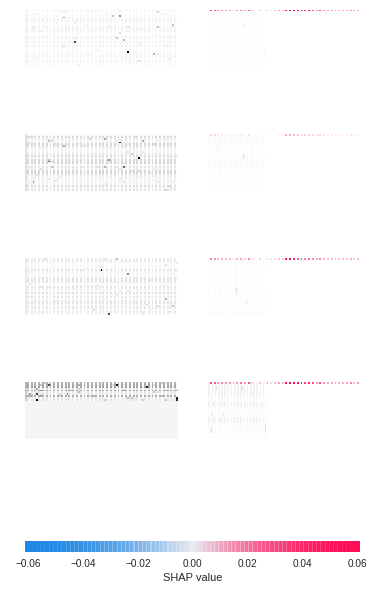

In [21]:
shap.image_plot(r_shap_values[0], -test, show=True) #this is with 100 random samples (= 4 tensors)

In [31]:
shap.initjs()
shap.force_plot(e_r.expected_value[0], r_shap_values[0][0][0], test[0][0])

In [23]:
shap.initjs()
shap.force_plot(e_r.expected_value[0], r_shap_values[0][0], test[0])

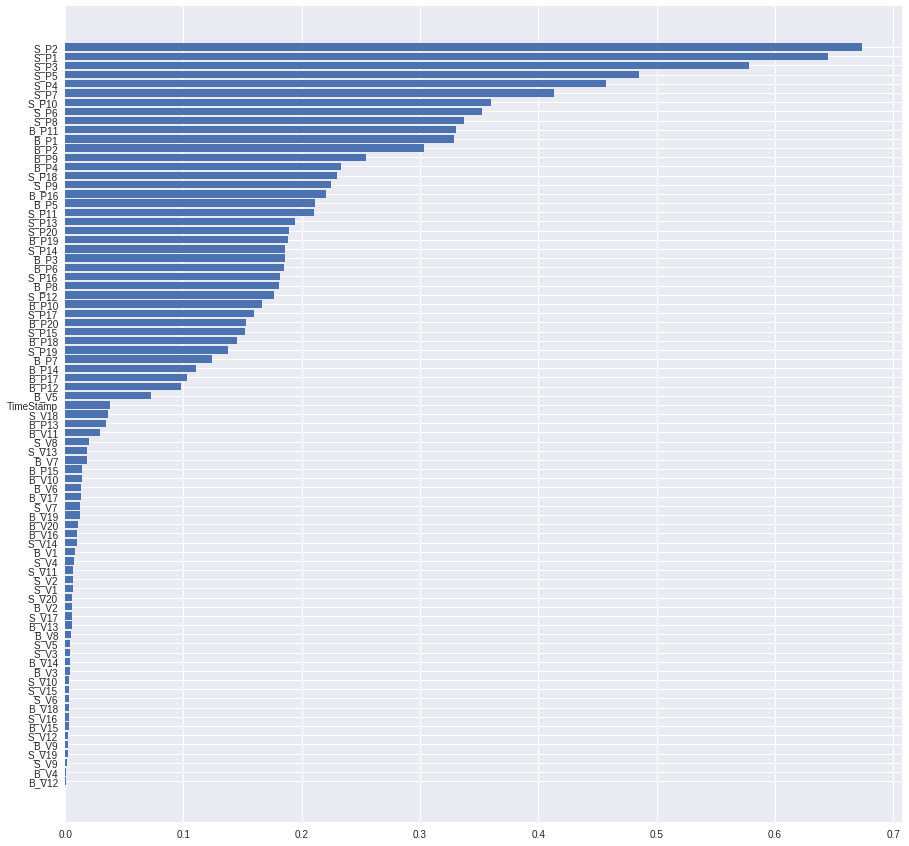

In [32]:
#results with background_1

shap_val = e_r.shap_values(test)
shap_val = shap_val[0]
shap_abs = np.absolute(shap_val)

sum_0 = np.sum(shap_abs, axis=0)

f_names = data.columns[:-1].tolist()

f_shap = dict(zip(sum_0[0], f_names))

a = sorted(list(f_shap.items()))
sorted_f = []
sorted_shap = []
for i in range(len(a)):
  sorted_f.append(a[i][1])
  sorted_shap.append(a[i][0]) 
  
x_pos = [i for i,_ in enumerate(f_names)]
plt.figure(figsize=(15, 15))
fig = plt.subplot(111)
fig.barh(x_pos, sorted_shap)
fig.set_yticks(x_pos)
fig.set_yticklabels(sorted_f)
plt.show()

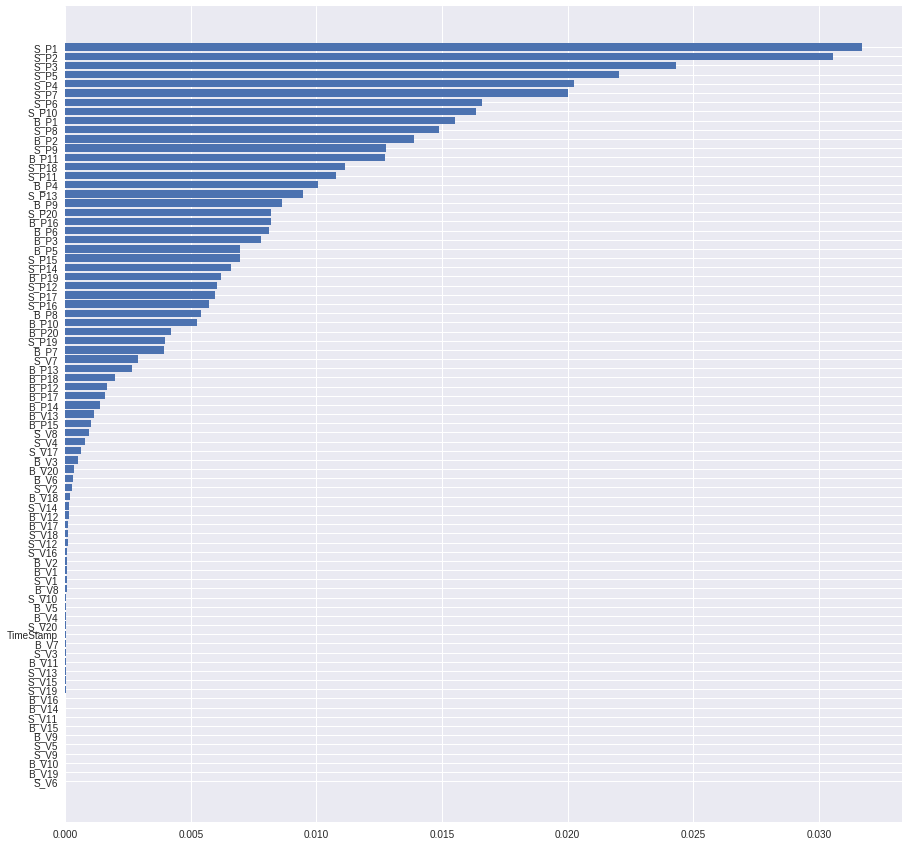

In [313]:
#results with background_2

shap_val = e_r.shap_values(test)
shap_val = shap_val[0]
shap_abs = np.absolute(shap_val)

sum_0 = np.sum(shap_abs, axis=0)

f_names = data.columns[:-1].tolist()

f_shap = dict(zip(sum_0[0], f_names))

a = sorted(list(f_shap.items()))
sorted_f = []
sorted_shap = []
for i in range(len(a)):
  sorted_f.append(a[i][1])
  sorted_shap.append(a[i][0]) 
  
x_pos = [i for i,_ in enumerate(f_names)]
plt.figure(figsize=(15, 15))
fig = plt.subplot(111)
fig.barh(x_pos, sorted_shap)
fig.set_yticks(x_pos)
fig.set_yticklabels(sorted_f)
plt.show()

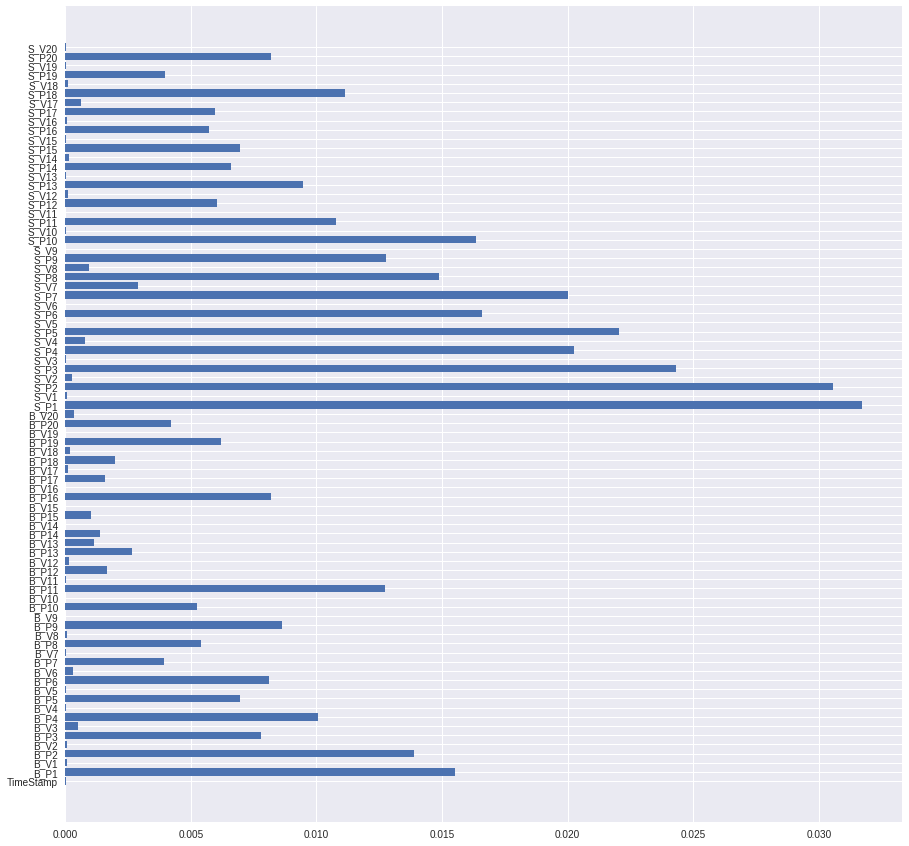

In [286]:
shap_val = e_r.shap_values(test)
shap_val = shap_val[0]
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs, axis=0)
cols = data_c.columns.tolist()
f_names = cols[:-1]
x_pos = [i for i,_ in enumerate(f_names)]
plt.figure(figsize=(15, 15))
fig = plt.subplot(111)
fig.barh(x_pos, sum_0[0])
fig.set_yticks(x_pos)
fig.set_yticklabels(f_names)
plt.show()

**Classification Model:**

In [148]:
data_c = pd.read_csv(file_1)
data_c.rename(columns={'Unnamed: 0':'TimeStamp'}, inplace=True)

data_c['Next_mid'] = data_c.Mid.shift(-1)
data_c.dropna(axis=0, inplace=True) #drop the last row which is now Nan

data_c['Price_move'] = data_c.Next_mid - data_c.Mid

data_c['up_or_down'] = np.where(data_c['Price_move']<0, 0, 1) #for now defining Price_move=0 as 1 (there are only 37 records where the next price didnt move)

data_c.drop(['Mid', 'Next_mid', 'Price_move'], axis=1, inplace=True) #deleting Mid and the other extra columns 

data_c.head()

,TimeStamp,B_P1,B_V1,B_P2,B_V2,B_P3,B_V3,B_P4,B_V4,B_P5,B_V5,B_P6,B_V6,B_P7,B_V7,B_P8,B_V8,B_P9,B_V9,B_P10,B_V10,B_P11,B_V11,B_P12,B_V12,B_P13,B_V13,B_P14,B_V14,B_P15,B_V15,B_P16,B_V16,B_P17,B_V17,B_P18,B_V18,B_P19,B_V19,B_P20,B_V20,S_P1,S_V1,S_P2,S_V2,S_P3,S_V3,S_P4,S_V4,S_P5,S_V5,S_P6,S_V6,S_P7,S_V7,S_P8,S_V8,S_P9,S_V9,S_P10,S_V10,S_P11,S_V11,S_P12,S_V12,S_P13,S_V13,S_P14,S_V14,S_P15,S_V15,S_P16,S_V16,S_P17,S_V17,S_P18,S_V18,S_P19,S_V19,S_P20,S_V20,up_or_down
0,1.521332e+09,0.069306,0.334,0.069309,0.015,0.069313,0.367,0.069314,4.328,0.069316,0.400,0.069319,0.016,0.069337,0.299,0.069343,0.275,0.069360,0.130,0.069363,0.109,0.069373,20.000,0.069374,0.536,0.069376,0.074,0.069378,0.040,0.069400,1.219,0.069404,0.269,0.069406,0.084,0.069416,0.090,0.069429,0.327,0.069430,0.864,0.069556,0.000,0.069556,0.000,0.069556,0.00,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.000,0.069556,0.00,0.069556,0.0,0.069556,0.0,0.069557,0.000,0.069556,1.724,0.069557,0.283,0.069558,4.166,0.069559,0.870,0.069560,23.200,0.069568,0.372,0.069569,1.248,0
1,1.521333e+09,0.069009,0.334,0.069010,0.279,0.069011,0.030,0.069012,0.016,0.069016,0.350,0.069030,0.058,0.069039,0.320,0.069042,0.539,0.069050,0.500,0.069054,0.015,0.069065,0.179,0.069076,0.129,0.069082,0.184,0.069095,0.261,0.069099,0.370,0.069100,5.115,0.069105,3.040,0.069106,3.441,0.069160,0.471,0.069161,0.328,0.069216,0.000,0.069216,0.000,0.069216,0.00,0.069216,0.000,0.069216,0.000,0.069216,0.000,0.069217,0.000,0.069217,0.000,0.069217,0.000,0.069218,0.00,0.069219,0.0,0.069221,0.0,0.069226,0.000,0.069215,1.451,0.069237,0.500,0.069238,0.001,0.069241,0.278,0.069244,1.933,0.069247,0.536,0.069250,19.809,0
2,1.521333e+09,0.068680,1.000,0.068690,1.001,0.068694,0.475,0.068695,2.238,0.068700,0.111,0.068708,0.350,0.068710,5.000,0.068715,0.050,0.068733,0.275,0.068739,0.370,0.068740,1.149,0.068741,0.410,0.068743,0.390,0.068749,0.015,0.068750,0.404,0.068751,0.080,0.068778,5.188,0.068779,2.916,0.068780,0.676,0.068781,0.390,0.068873,0.000,0.068873,0.000,0.068873,0.00,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.000,0.068873,0.00,0.068873,0.0,0.068873,0.0,0.068873,0.000,0.068874,0.000,0.068873,1.528,0.068874,1.332,0.068875,1.362,0.068879,0.075,0.068896,1.400,0.068899,5.695,0
3,1.521333e+09,0.068332,0.147,0.068340,1.317,0.068341,0.159,0.068350,4.000,0.068358,5.000,0.068359,0.365,0.068368,1.034,0.068371,0.261,0.068378,0.299,0.068390,0.320,0.068400,0.897,0.068409,0.705,0.068411,0.320,0.068413,0.330,0.068424,0.984,0.068452,0.808,0.068465,25.135,0.068467,0.897,0.068470,0.247,0.068473,0.523,0.068547,0.481,0.068548,3.345,0.068550,0.35,0.068560,0.527,0.068592,0.758,0.068601,0.889,0.068602,0.841,0.068603,0.759,0.068606,2.014,0.068620,2.46,0.068642,0.1,0.068644,5.2,0.068649,0.275,0.068663,0.159,0.068664,0.334,0.068670,0.684,0.068673,0.635,0.068678,5.586,0.068679,0.056,0.068680,2.021,0
4,1.521334e+09,0.068062,0.320,0.068064,0.819,0.068067,0.400,0.068069,0.040,0.068070,0.707,0.068071,1.049,0.068074,0.200,0.068075,0.015,0.068090,0.533,0.068095,0.090,0.068096,0.293,0.068099,0.335,0.068100,1.191,0.068105,0.673,0.068110,1.182,0.068115,0.262,0.068118,0.110,0.068140,2.142,0.068148,0.507,0.068155,0.575,0.068233,0.000,0.068233,0.000,0.068233,0.00,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068233,0.00,0.068233,0.0,0.068233,0.0,0.068233,0.000,0.068233,0.000,0.068233,0.000,0.068234,0.000,0.068233,4.103,0.068234,1.311,0.068236,1.575,0.068245,0.939,0


In [0]:
#using all samples
X_y = data_c.values
y = np.expand_dims(X_y[:-1000, -1], axis=1) #is binary and needs to change to categorical instead of scaling
X = X_y[:-1000,:-1]

In [150]:
y_binary = to_categorical(y)
print(y_binary.shape)

(8513, 2)


In [0]:
pipeline = Pipeline([('scaler', StandardScaler())])
X = pipeline.fit_transform(X)

In [152]:
X_train, y_train, X_test, y_test = train_test_split(X, y_binary)  
print(len(X_train), len(y_train), len(X_test), len(y_test))

6810 6810 1703 1703


In [153]:
batch_size = 30 

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)

(227, 30, 81) (227, 30, 2)
(57, 30, 81) (57, 30, 2)


In [154]:
X_y = data_c.values
y = np.expand_dims(X_y[:-1000, -1], axis=1) 
X = X_y[:-1000,:-1]

y_binary = to_categorical(y)
print(y_binary.shape)

pipeline = Pipeline([('scaler', StandardScaler())])
X = pipeline.fit_transform(X)

X_train, y_train, X_test, y_test = train_test_split(X, y_binary)  
print(len(X_train), len(y_train), len(X_test), len(y_test))

batch_size = 30 

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)

(8513, 2)
6810 6810 1703 1703
(227, 30, 81) (227, 30, 2)
(57, 30, 81) (57, 30, 2)


In [0]:
def classification_result(y_pred, thresh=0.5):
  cutt_off_tr = thresh # some threshold

  y_pred[np.where(y_pred >= cutt_off_tr)] = 1 
  y_pred[np.where(y_pred < cutt_off_tr)]  = 0

  print(confusion_matrix(
         _3d_to_2d(y_test_batch)[:, 1], 
         _3d_to_2d(y_pred)[:, 1]))

  print()
  print(classification_report(
          _3d_to_2d(y_test_batch)[:, 1], 
          _3d_to_2d(y_pred)[:, 1],
          target_names = ["Down", "Up"],
          digits = 5))
 

In [156]:
#First this model is WRONG!!! It has been trained on test data and therefore when you test it on test data the magnificant high accuracy it produces!!!

from keras.models import load_model

model_c = '/content/drive/My Drive/Vega/MachineLearning/data/binance/classification_128n'
model_c = load_model(model_c)

y_c = model_c.predict(X_test_batch)
classification_result(y_c)

[[716   7]
 [  2 985]]

             precision    recall  f1-score   support

       Down    0.99721   0.99032   0.99375       723
         Up    0.99294   0.99797   0.99545       987

avg / total    0.99475   0.99474   0.99473      1710



In [0]:
#background_1 = X_train[np.random.choice(X_train.shape[0], 30, replace=False)] #100 samples with batch_Size of 30 gives 4 tensors, change 100 to 30 to get 1 tensor
background_2 = X_train[:30]
background = reshape_to_batches(background_2, 30)


In [0]:
#test = X_test[np.random.choice(X_test.shape[0], 60, replace=False)]

test = X_test_batch[27]
test = reshape_to_batches(test, 30)

In [0]:
e_c = shap.DeepExplainer((model_c.input, model_c.output[:,0]), background)

c_shap_values = e_c.shap_values(test)

In [230]:
print(e_c.expected_value)
print(len(c_shap_values), c_shap_values[0].shape)

[0.9451974  0.05480257]
2 (1, 30, 81)


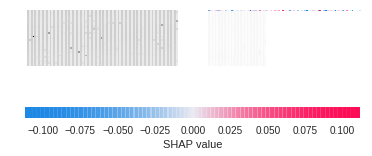

In [172]:
#The shap_values object above is a list with two arrays. The first array is the SHAP values for a 0 outcome (price moves down), and the second array is the 
#list of SHAP values for the 1 outcome (price moves up). We'll pull out Shap values for 0 (shap_values[0])

shap.image_plot(c_shap_values[0], -background, show=True) #each row is shap values for a tensor

In [187]:
shap.initjs()
shap.force_plot(e_c.expected_value[0], c_shap_values[0][0][0], background[0][0])

In [178]:
shap.initjs()
shap.force_plot(e_c.expected_value[0], c_shap_values[0][0][0], test[0][0])


In [177]:
shap.initjs()
shap.force_plot(e_c.expected_value[0], c_shap_values[0][0], test[0][0])

In [179]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 120 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 30/30 [00:00<00:00, 64.65it/s]


In [180]:
X_test

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
114,5.8,2.8,5.1,2.4
62,6.0,2.2,4.0,1.0
33,5.5,4.2,1.4,0.2
107,7.3,2.9,6.3,1.8
7,5.0,3.4,1.5,0.2
100,6.3,3.3,6.0,2.5
40,5.0,3.5,1.3,0.3
86,6.7,3.1,4.7,1.5
76,6.8,2.8,4.8,1.4
71,6.1,2.8,4.0,1.3


In [0]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

NameError: ignored